Fit interpretable models to the training set and test on validation sets. Uses imodels package as of 10/25/2020.

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
import viz
import pickle as pkl
import matplotlib.pyplot as plt
from os.path import join as oj
import os
import numpy as np
from dtreeviz.trees import *
import imodels
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

import data
import validate
outcome_def = 'iai_intervention' # output
MODELS_DIR = '../models/simple_3_splits'
os.makedirs(MODELS_DIR, exist_ok=True)


# load the data
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

# split the idxs
train_idxs = df.cv_fold.isin(data.pecarn_train_idxs)
test_idxs1 = df.cv_fold.isin(data.pecarn_test_idxs)
test_idxs2 = df.cv_fold.isin(data.psrc_train_idxs + data.psrc_test_idxs)

# split the data
X, y = df[processed_feats], df[outcome_def]
half = train_idxs.sum() // 2
split_to_plot = '_test2'

# 3-split
X_train, y_train = X[train_idxs], y[train_idxs]
X_cv, y_cv = X_train, y_train
X_test1, y_test1 = X[test_idxs1], y[test_idxs1]

# try loading psrc data
if df_psrc.shape[0] > 0:
    X_test2, y_test2 = X[test_idxs2], y[test_idxs2]
else:
    X_test2, y_test2 = X_test1, y_test1
    
data_sizes = {
    'train': (y_train.sum(), X_train.shape[0]),
    'cv': (y_cv.sum(), X_cv.shape[0]),
    'test1': (y_test1.sum(), X_test1.shape[0]),
    'test2': (y_test2.sum(), X_test2.shape[0]),
}

def predict_and_save(model, model_name='decision_tree', split_to_plot='_cv'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_test1, X_test2, X_cv], [y_train, y_test1, y_test2, y_cv], 
                            ['_train', '_test1', '_test2', '_cv']):
        stats, threshes = validate.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                  plot=suffix == split_to_plot)
        plt.title(split_to_plot[1:])
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
#         results['sens' + suffix] = sens
#         results['spec' + suffix] = spec
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))        
    return stats, threshes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# fit simple models

**decision tree**

In [ ]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=4, class_weight={0:1, 1:1e3})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree', split_to_plot=split_to_plot)
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

# visualize tree
# dviz = dtreeviz(dt,
#                X_train,
#                y_train.values,
#                feature_names=list(X_train),
#                class_names=["healty", "iai-i"],
#                fancy=True)
# dviz

**bayesian rule list**

In [ ]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = imodels.BayesianRuleListClassifier(listlengthprior=2, max_iter=10000, class1label="IwI", verbose=False)
brl.fit(X_train, y_train, feature_labels=processed_feats)
stats, threshes = predict_and_save(brl, model_name='bayesian_rule_list', split_to_plot=split_to_plot)
print(brl)

In [22]:
print(brl)

Trained RuleListClassifier for detecting IwI
IF GCSScore_Full_yes_0.5_to_inf AND AbdTenderDegree_None_0.5_to_inf THEN probability of IwI: 0.3% (0.2%-0.5%)
ELSE IF DecrBreathSound_yes_0.5_to_inf AND ThoracicTrauma_yes_0.5_to_inf THEN probability of IwI: 23.3% (13.6%-34.7%)
ELSE IF AbdTrauma_or_SeatBeltSign_yes_-inf_to_0.5 AND Hypotension_yes_-inf_to_0.5 THEN probability of IwI: 1.6% (1.1%-2.1%)
ELSE IF GCSScore_Full_yes_0.5_to_inf THEN probability of IwI: 5.3% (3.7%-7.2%)
ELSE probability of IwI: 20.7% (15.0%-27.0%)



**rulefit**

100%|██████████| 220/220 [00:13<00:00, 15.46it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

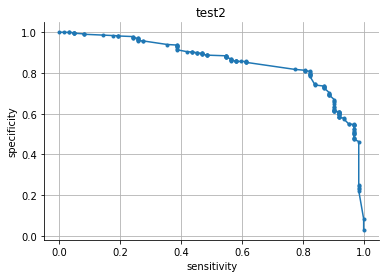

In [5]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitRegressor(max_rules=4)
rulefit.fit(X_train, y_train, feature_names=processed_feats)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit', split_to_plot=split_to_plot)
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [7]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
1,AbdTenderDegree_None,-0.011
2,AbdTrauma_or_SeatBeltSign_yes,0.040
4,CostalTender_yes,0.011
6,GCSScore_Full_yes,-0.041
8,MOI_Bike_collision/fall,0.002
10,MOI_Motor_vehicle_collision,0.009
11,MOI_Motorcycle/ATV/Scooter_collision,-0.001
12,MOI_Object_struck_abdomen,-0.001
14,ThoracicTrauma_yes,0.008
15,VomitWretch_yes,0.015


**slim - sparse linear integer model**

In [ ]:
fewest_feats = data.fewest_feats
CLASS_WEIGHT = 100
n = X_train.shape[0]
lambda_reg = 10

# optionally upweight positive samples
sample_weight = np.ones((n))
sample_weight[y_train[:n] == 1] *= CLASS_WEIGHT
sample_weight /= sample_weight.max()

# fit
X_train_small = X_train[fewest_feats]
slim = imodels.SLIMRegressor()
slim.fit(X_train_small[:n], y_train[:n] * 100, lambda_reg=lambda_reg,
         sample_weight=sample_weight)

# calculate mse on the training data
# sens, spec, threshes = predict_and_save(slim, model_name='slim')

X_test_small = X_test1[fewest_feats]
# preds = slim.predict(X_test_small)
# preds_proba = [1 / (1 + np.exp(-y)) for y in preds]
preds_proba = slim.predict_proba(X_test_small)
print('considered ', len(fewest_feats), 'feats')
coefs = slim.model.coef_.astype(int)
intercept = slim.model.intercept_
for i in range(len(fewest_feats)):
    if coefs[i] != 0:
        print(fewest_feats[i], coefs[i])
print('intercept', intercept)
stats, threshes = validate.all_stats_curve(y_test1, preds_proba[:, 1], plot=True)

**skope rules**

In [7]:
# # feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
# clf = imodels.SkopeRulesClassifier(max_depth_duplication=100,
#                  n_estimators=100,
#                  precision_min=0.01, # per rule precision min
#                  recall_min=0.1,     # per rule recall min
#                  feature_names=processed_feats)
# clf.fit(X_train, y_train)
# # print the rules
# rules = clf.rules_
# print("Rules for iai")
# for rule in rules:
#     print(rule)

# # evaluate
# sens, spec, threshes = predict_and_save(clf, model_name='skope', split_to_plot=split_to_plot)

# plt.show()

**greedy (CART) rule list**

/accounts/projects/vision/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/accounts/projects/vision/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
  0%|          | 0/9 [00:00<?, ?it/s]

1.67 -> Hypotension_yes -> 1.45 (7869) 16.38 (116)
1.45 -> AbdTrauma_or_SeatBeltSign_yes -> 0.78 (6657) 5.12 (1212)
0.78 -> DecrBreathSound_yes -> 0.66 (6529) 7.03 (128)
0.66 -> ThoracicTrauma_yes -> 0.58 (5709) 1.22 (820)
0.58 -> MOI_Motor vehicle collision -> 0.47 (4011) 0.82 (1698)
0.47 -> MOI_Bike collision/fall -> 0.43 (3740) 1.11 (271)
0.43 -> MOI_Motorcycle/ATV/Scooter collision -> 0.40 (3481) 0.77 (259)
0.40 -> MOI_Fall from an elevation -> 0.35 (2305) 0.51 (1176)
0.35 -> VomitWretch_yes -> 0.33 (2116) 0.53 (189)


100%|██████████| 9/9 [00:00<00:00, 33.64it/s]


	                                    => 1.67% risk (7985 pts)
                         if Hypotension_yes ===> 16.4% risk (116 pts)
	                                    => 1.45% risk (7869 pts)
           if AbdTrauma_or_SeatBeltSign_yes ===> 5.1% risk (1212 pts)
	                                    => 0.78% risk (6657 pts)
                     if DecrBreathSound_yes ===> 7.0% risk (128 pts)
	                                    => 0.66% risk (6529 pts)
                      if ThoracicTrauma_yes ===> 1.2% risk (820 pts)
	                                    => 0.58% risk (5709 pts)
             if MOI_Motor vehicle collision ===> 0.8% risk (1698 pts)
	                                    => 0.47% risk (4011 pts)
                 if MOI_Bike collision/fall ===> 1.1% risk (271 pts)
	                                    => 0.43% risk (3740 pts)
    if MOI_Motorcycle/ATV/Scooter collision ===> 0.8% risk (259 pts)
	                                    => 0.4% risk (3481 pts)
              if MO

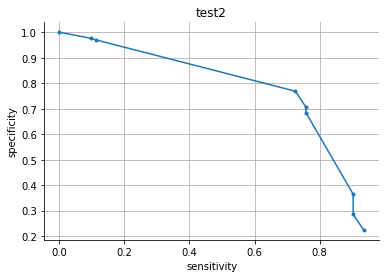

In [6]:
class_weight = {0: 1, 1: 100}
d = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, verbose=True)
stats, threshes = predict_and_save(d, model_name='grl', split_to_plot=split_to_plot)
d.print_list()

**irf - iterative Random Forest**

100%|██████████| 269/269 [00:07<00:00, 34.49it/s]


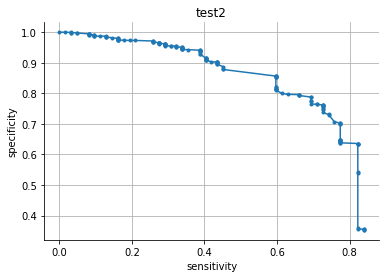

In [5]:
# specify a decision tree with a maximum depth
from irf.ensemble.wrf import RandomForestClassifierWithWeights as IRFClassifier
irf = IRFClassifier()
irf.fit(X_train, y_train)
stats, threshes = predict_and_save(irf, model_name='irf', split_to_plot=split_to_plot)
# sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1], plot=True)

In [ ]:
imps = irf.model.feature_importances_.round(3)
args = np.argsort(imps)[::-1]
imps = imps[args]
feats = np.array(processed_feats)[args]
for imp, feat in zip(imps, feats):
    print(feat, imp)

# # visualize one tree
# dviz = dtreeviz(irf.model.estimators_[-1],
#                X_train,
#                y_train.values,
#                feature_names=list(X_train),
#                class_names=["healty", "iai-i"],
#                fancy=True)
# dviz

**rf**

In [11]:
# # specify a decision tree with a maximum depth
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# sens, spec, threshes = predict_and_save(rf, model_name='rf')
# # sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1], plot=True)
# imps = rf.feature_importances_.round(3)
# args = np.argsort(imps)
# imps = imps[args]
# feats = np.array(processed_feats)[args]
# for imp, feat in zip(imps, feats):
#     print(feat, imp)

# look at all the results

In [ ]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
        #         print(r)
#                 print(r.keys())
                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=viz.rename(fname[:-4]), alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)
                
                # print best results
                if suffix == '_test2': 
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')
                    
    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'o', color='black', label='Original CDR', ms=4)
    else:
        plt.plot(97.0, 42.5, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()



suffixes = ['_train', '_test1', '_test2',] # _train, _test1, _test2, _cv    
titles = ['Training (PECARN)', 'Validation (PECARN)', 'Test (PSRC)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
#         ax.yaxis.set_visible(False) 
    plt.xlim((50, 101))
    plt.ylim((0, 101))    
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
viz.savefig('metrics_3_splits')
plt.show()

'''x
plt.figure(dpi=200, figsize=(C * 6, R * 6))
for i, suffix in enumerate(suffixes):
    plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i])
    plt.xlim((80, 101))
    plt.ylim((25, 70))
plt.subplot(R, C, 1)    
plt.legend()
plt.tight_layout()
viz.savefig('metrics_3_splits_zoom')
plt.show()
plt.legend(bbox_to_anchor=(1.05, 1.05))
'''

In [8]:
def print_metrics(suffix):
    vals = {s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-']}
    fnames = []
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                threshes = np.array(r['threshes' + suffix])
                
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                best_idx = np.argmax(5 * sens + spec)
                for k in vals.keys():
                    vals[k].append(r[k + suffix][best_idx])
                fnames.append(viz.rename(fname[:-4]))
    stats = pd.DataFrame.from_dict(vals)
    stats.index = fnames
    return (stats).round(2).transpose()

suffixes = ['_test1', '_test2',] # _train, _test1, _test2
stats_list = []
for i, suffix in enumerate(suffixes):
    stats_list.append(print_metrics(suffix))

In [9]:
stats_list[0]

,Bayesian rule list,CART decision tree,CART rule list,Iterative random forest
sens,0.90,0.84,0.91,0.73
spec,0.58,0.56,0.28,0.68
ppv,0.04,0.03,0.02,0.04
npv,1.00,1.00,0.99,0.99
lr+,2.13,1.93,1.26,2.29
lr-,0.17,0.28,0.31,0.40


In [10]:
stats_list[1]

,Bayesian rule list,CART decision tree,CART rule list,Iterative random forest
sens,0.95,0.94,0.94,0.82
spec,0.60,0.60,0.22,0.64
ppv,0.07,0.06,0.03,0.06
npv,1.00,1.00,0.99,0.99
lr+,2.39,2.33,1.21,2.26
lr-,0.08,0.11,0.29,0.28
